<a href="https://colab.research.google.com/github/bilnazir/stockmarketprediction/blob/main/fyp_GRU_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=3065dde7476bd2ba3e07738bb6a477c4b27e8f435c2100a0f20e1820a7ec3c75
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [2]:
 # Module import
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.stats import median_abs_deviation
from tensorflow.keras import layers, models, optimizers, losses, callbacks,\
                             regularizers
from tensorflow.keras.optimizers import Nadam, RMSprop
import pandas_ta as ta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

In [3]:
df = yf.download(tickers = 'GOOG', start = '2012-03-11',end = '2022-07-10')

df_3 = df.dropna()
df_3

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-12,14.943986,15.118333,14.925555,15.072255,15.055123,67010233
2012-03-13,15.161919,15.388570,15.082218,15.386826,15.369336,90168712
2012-03-14,15.317586,15.511360,15.279230,15.342244,15.324805,117916329
2012-03-15,15.357437,15.529292,15.313352,15.470264,15.452680,97769094
2012-03-16,15.464286,15.589317,15.443364,15.567649,15.549953,122477361
...,...,...,...,...,...,...
2022-07-01,108.336998,109.806351,107.105003,109.081001,108.957016,31028000
2022-07-05,107.514503,114.052597,106.249496,113.887001,113.757553,36398000
2022-07-06,114.092003,116.351997,112.250504,115.213501,115.082542,28852000


In [4]:
# Stock indicators for Processing

df_3['RSI']=ta.rsi(df_3.Close, length=15)
df_3['EMAF']=ta.ema(df_3.Close, length=20)
df_3['EMAM']=ta.ema(df_3.Close, length=100)
df_3['EMAS']=ta.ema(df_3.Close, length=150)

df_3['Target'] = df_3['Adj Close']-df_3.Open
df_3['Target'] = df_3['Target'].shift(-1)

df_3['TargetClass'] = [1 if df_3.Target[i]>0 else 0 for i in range(len(df_3))]

df_3['Target Adj Close'] = df_3['Adj Close'].shift(-1)

df_3.dropna(inplace=True)
df_3.reset_index(inplace = True)
df_3.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)
df_3


<ipython-input-4-c6e0b158a695>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_3['TargetClass'] = [1 if df_3.Target[i]>0 else 0 for i in range(len(df_3))]


,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,Target Adj Close
0,18.752213,18.891689,18.687206,18.695570,63.114599,18.472997,16.750024,15.845736,-0.197922,0,18.528139
1,18.726061,18.801277,18.533033,18.528139,58.291437,18.480257,16.785651,15.881544,-0.044888,0,18.434347
2,18.479235,18.526308,18.199286,18.434347,55.735068,18.477882,16.818714,15.915634,0.092741,1,18.526896
3,18.434155,18.605015,18.342747,18.526896,57.696439,18.484558,16.852957,15.950499,0.266031,1,18.795330
4,18.529299,18.837891,18.437391,18.795330,62.816630,18.516192,16.891843,15.988463,-1.527525,0,17.290442
...,...,...,...,...,...,...,...,...,...,...,...
2444,110.499496,111.329803,107.309998,109.248177,44.116090,112.576590,122.131961,125.171556,0.620018,1,108.957016
2445,108.336998,109.806351,107.105003,108.957016,43.739444,112.243677,121.873526,124.958436,6.243050,1,113.757553
2446,107.514503,114.052597,106.249496,113.757553,51.112515,112.400184,121.715377,124.811795,0.990540,1,115.082542
2447,114.092003,116.351997,112.250504,115.082542,52.936476,112.668119,121.586627,124.684665,3.162384,1,119.170387


In [6]:
df_4 = df_3.iloc[:, 0:11]
pd.set_option('display.max_columns', None)
df_4.head(10)
df_4

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,Target Adj Close
0,18.752213,18.891689,18.687206,18.695570,63.114599,18.472997,16.750024,15.845736,-0.197922,0,18.528139
1,18.726061,18.801277,18.533033,18.528139,58.291437,18.480257,16.785651,15.881544,-0.044888,0,18.434347
2,18.479235,18.526308,18.199286,18.434347,55.735068,18.477882,16.818714,15.915634,0.092741,1,18.526896
3,18.434155,18.605015,18.342747,18.526896,57.696439,18.484558,16.852957,15.950499,0.266031,1,18.795330
4,18.529299,18.837891,18.437391,18.795330,62.816630,18.516192,16.891843,15.988463,-1.527525,0,17.290442
...,...,...,...,...,...,...,...,...,...,...,...
2444,110.499496,111.329803,107.309998,109.248177,44.116090,112.576590,122.131961,125.171556,0.620018,1,108.957016
2445,108.336998,109.806351,107.105003,108.957016,43.739444,112.243677,121.873526,124.958436,6.243050,1,113.757553
2446,107.514503,114.052597,106.249496,113.757553,51.112515,112.400184,121.715377,124.811795,0.990540,1,115.082542
2447,114.092003,116.351997,112.250504,115.082542,52.936476,112.668119,121.586627,124.684665,3.162384,1,119.170387


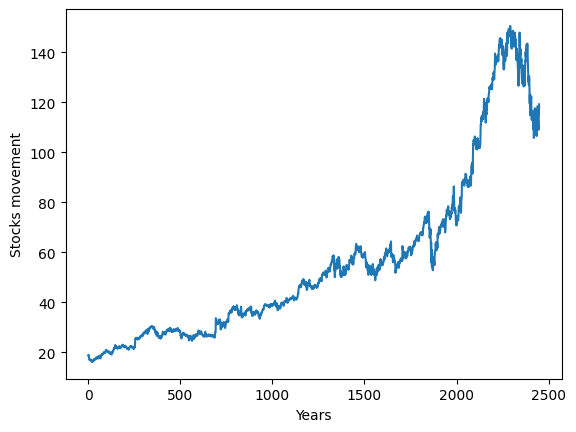

In [7]:
df_4_AC=df_4['Adj Close']
plt.ylabel('Stocks movement')
plt.xlabel('Years')
plt.plot(df_4_AC)

In [8]:
sc = MinMaxScaler(feature_range=(0,1))
df_4_scaled = sc.fit_transform(df_3)
print(df_4_scaled)

[[0.01961177 0.01934069 0.02123572 ... 0.45654945 0.         0.0180559 ]
 [0.01941916 0.01867509 0.02008558 ... 0.46732147 0.         0.01735823]
 [0.01760124 0.01665081 0.01759579 ... 0.47700908 1.         0.01804665]
 ...
 [0.6733618  0.71990078 0.67445715 ... 0.54020474 1.         0.73626929]
 [0.72180625 0.73682861 0.71922513 ... 0.69307994 1.         0.76667645]
 [0.73591794 0.76266871 0.74372024 ... 0.64518171 1.         0.77308485]]


In [9]:
# Multiple feature for data
X = []

backcandles = 40
print(df_4_scaled.shape[0])
for j in range(8):  # Targeted columns 2
    X.append([])
    for i in range(backcandles, df_4_scaled.shape[0]):#backcandles+2
        X[j].append(df_4_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])
X, yi =np.array(X), np.array(df_4_scaled[backcandles:,-1]) #scaling backwards
y=np.reshape(yi,(len(yi),1))
print(X)
print(X.shape)
print(y)
print(y.shape)

2449
[[[1.96117689e-02 1.93406886e-02 2.12357171e-02 ... 1.33156042e-02
   0.00000000e+00 0.00000000e+00]
  [1.94191573e-02 1.86750882e-02 2.00855754e-02 ... 1.33712291e-02
   2.85163557e-04 2.95199332e-04]
  [1.76012387e-02 1.66508076e-02 1.75957906e-02 ... 1.33530347e-02
   5.49797855e-04 5.76235737e-04]
  ...
  [7.63117572e-03 7.80924125e-03 9.01343217e-03 ... 1.86867438e-03
   8.81992476e-04 3.62543765e-03]
  [8.99048456e-03 8.04210731e-03 8.62509518e-03 ... 1.91414451e-03
   9.10704816e-04 3.70797280e-03]
  [7.22760588e-03 7.08314961e-03 8.87965141e-03 ... 1.97727710e-03
   9.43625311e-04 3.79270560e-03]]

 [[1.94191573e-02 1.86750882e-02 2.00855754e-02 ... 1.33712291e-02
   2.85163557e-04 2.95199332e-04]
  [1.76012387e-02 1.66508076e-02 1.75957906e-02 ... 1.33530347e-02
   5.49797855e-04 5.76235737e-04]
  [1.72692151e-02 1.72302346e-02 1.86660225e-02 ... 1.34041860e-02
   8.23876921e-04 8.63666809e-04]
  ...
  [8.99048456e-03 8.04210731e-03 8.62509518e-03 ... 1.91414451e-03
   9.

In [10]:
# split data into training and testing
train_test_split = int(len(X)*0.7)
print(train_test_split)
X_train, X_test = X[:train_test_split], X[train_test_split:]
y_train, y_test = y[:train_test_split], y[train_test_split:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1686
(1686, 40, 8)
(723, 40, 8)
(1686, 1)
(723, 1)
[[0.00932311]
 [0.01027431]
 [0.01013736]
 ...
 [0.32278361]
 [0.32214465]
 [0.30793852]]


In [11]:
# Define the input shape
input_shape = (backcandles, 8)
input_layer = layers.Input(shape=input_shape, name='Input')

# GRU Layer 1
gru_1 = layers.GRU(units=100, return_sequences=True, activation='tanh',
                   kernel_regularizer=regularizers.l2(0.001), dropout=0.1, recurrent_dropout=0.1)(input_layer)

# Additional GRU Layer
gru_2 = layers.GRU(units=50, return_sequences=False, activation='tanh')(gru_1)

# Dense Layer
dense_1 = layers.Dense(units=50, activation='relu')(gru_2)

# Output Layer
output_layer = layers.Dense(1, activation='linear')(dense_1)


# Create the model
gru_model = models.Model(inputs=input_layer, outputs=output_layer, name='GRU_Model')
gru_model.summary()


Model: "GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 40, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 40, 100)             │          33,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,401 (228.13 KB)

 Trainable params: 58,401 (228.13 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile the model
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])


In [13]:
# Train the model
history = gru_model.fit( X_train,
    y_train,
    batch_size=64,
    epochs=128,
    validation_data=(X_test, y_test),
    verbose=1,)

print(history.history.keys)

Epoch 1/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - loss: 0.0279 - mean_absolute_error: 0.0796 - val_loss: 0.0253 - val_mean_absolute_error: 0.1001
Epoch 2/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 0.0105 - mean_absolute_error: 0.0231 - val_loss: 0.0225 - val_mean_absolute_error: 0.1057
Epoch 3/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0072 - mean_absolute_error: 0.0166 - val_loss: 0.0225 - val_mean_absolute_error: 0.1137
Epoch 4/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.0055 - mean_absolute_error: 0.0164 - val_loss: 0.0212 - val_mean_absolute_error: 0.1133
Epoch 5/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - loss: 0.0044 - mean_absolute_error: 0.0154 - val_loss: 0.0178 - val_mean_absolute_error: 0.1027
Epoch 6/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.0036 - mean_absolute_error: 0.0157 - val_loss: 0.0182 - val_mean_absolute_error: 0.1079
Epoch 7/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - loss: 0.0031 - mean_absolute_error: 0.

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
[0.29756287] [0.31447689]
[0.29248625] [0.31408681]
[0.29089776] [0.31526819]
[0.29149678] [0.32337802]
[0.2911722] [0.32161338]
[0.2950879] [0.31429114]
[0.29681033] [0.31912807]
[0.29355192] [0.33026188]
[0.29375893] [0.32786569]
[0.29908377] [0.32767254]


<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

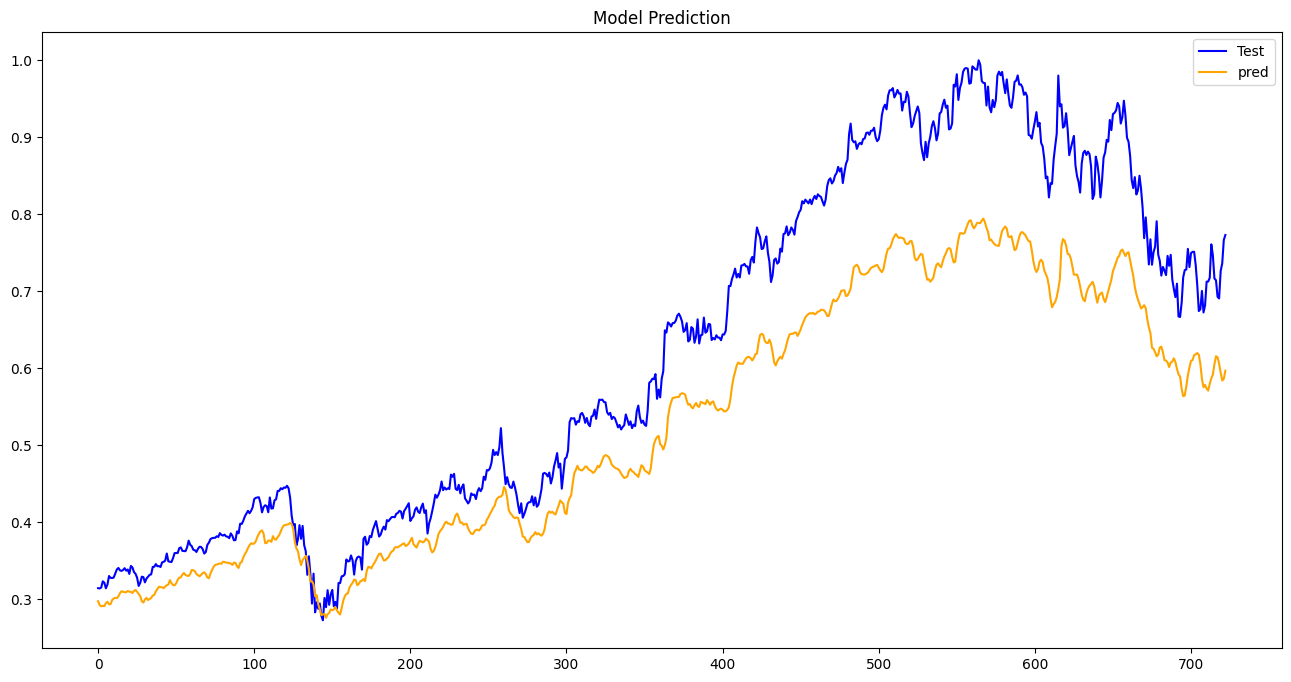

In [14]:
# Make predictions on test data

# Model prediction
y_pred = gru_model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

    plt.figure(figsize=(16,8))


plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'orange', label = 'pred')
plt.legend(loc=0)
plt.title('Model Prediction')
plt.show()

In [15]:
# Convert training history to datafram for viewing and graphing.
hist = pd.DataFrame(history.history)
hist.head()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.018423,0.047355,0.025276,0.100127
1,0.009668,0.021299,0.022502,0.105716
2,0.006778,0.016329,0.022533,0.113724
3,0.005251,0.016602,0.021192,0.113349
4,0.004217,0.015632,0.017765,0.102680


In [16]:
# Evaluate the model
loss = gru_model.evaluate(X_test, y_test, verbose=0)[0]  # Extract the loss value from the list
y_pred = gru_model.predict(X_test)
mae = np.mean(np.abs(y_pred - y_test))  # Calculate MAE manually

print(f"Test loss: {loss:.4f}, Test MAE: {mae:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test loss: 0.0135, Test MAE: 0.0978


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2) score: {r2:.4f}")

Mean Absolute Error (MAE): 0.0978
Mean Squared Error (MSE): 0.0134
Root Mean Squared Error (RMSE): 0.1160
R-squared (R2) score: 0.7359


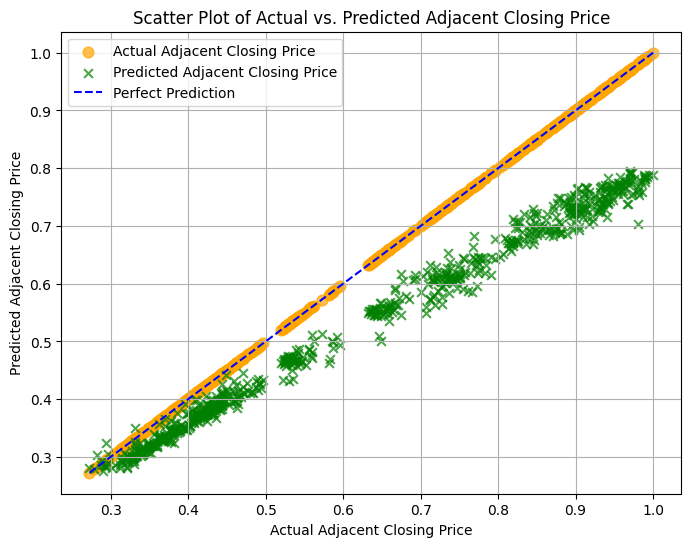

In [18]:
# Scatter plot of actual vs. predicted adjacent closing prices
plt.figure(figsize=(8, 6))  # Increase figure size for better visibility

# Plot actual values as orange circles with larger markers
plt.scatter(y_test, y_test, color='orange', label='Actual Adjacent Closing Price', alpha=0.7, s=60)

# Plot predicted values as black crosses with smaller markers
plt.scatter(y_test, y_pred, color='green', label='Predicted Adjacent Closing Price', alpha=0.7, s=40, marker='x')

# Plot the diagonal line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Adjacent Closing Price')
plt.ylabel('Predicted Adjacent Closing Price')
plt.title('Scatter Plot of Actual vs. Predicted Adjacent Closing Price')
plt.legend()
plt.grid(True)  # Add grid lines for better readability
plt.show()

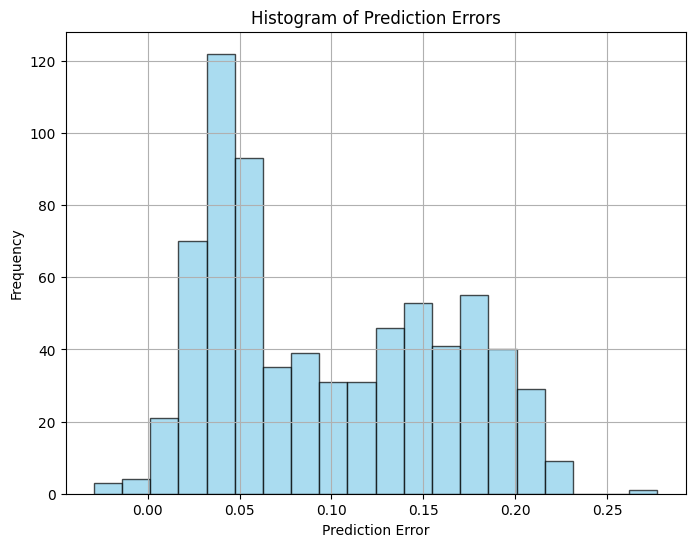

In [19]:
# Histogram of prediction errors
errors = y_test - y_pred

plt.figure(figsize=(8, 6))  # Increase figure size for better visibility

plt.hist(errors, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')

# Add grid lines for better readability
plt.grid(True)

plt.show()